In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import numpy as np
import os
import re
import time
import string
import glob

In [0]:
# Devices informations
print("Devices:\n", device_lib.list_local_devices())
print("GPU:", tf.test.gpu_device_name())

In [0]:
!git clone https://github.com/michalovsky/books_data.git

In [3]:
# Read all file paths from directory
directory = "books_data/kafka/"
file_paths = glob.glob(directory +"*.txt")    
print("Found", len(file_paths), "text files in directory:", directory)

Found 1 text files in directory: books_data/kafka/


In [4]:
# Extract text from all text files
text = ""

for file_path in file_paths:
    with open(file_path, 'r') as file:
        file_content = file.read()
        #remove file beginning and ending from gutenberg books
        file_content = file_content[file_content.find("*** START"):file_content.rfind("*** END")]
        #remove file ending from wolnelektury books
        file_content = file_content[:file_content.rfind("-----")]
        text+=file_content
print ('Length of text: {} characters'.format(len(text)))

Length of text: 119433 characters


In [0]:
# Preprocess data

punctuation_translator = str.maketrans('–—”„…«»‘’“', '          ', string.punctuation)
digits_translator = str.maketrans('', '', string.digits)
special_characters_translator = str.maketrans('ąćęłńóśźżäöüæèêéô', 'acelnoszzaoueeeeo', '')

# remove redundant characters and translate special characters
text = text.lower().translate(punctuation_translator).translate(digits_translator).translate(special_characters_translator)

# remove "tom <number>" strings 
text = re.sub(r"\ntom\s(.*)\n", "", text)

# remove "rozdzial <number>" strings 
text = re.sub(r"\nrozdzial\s(.*)\n", "", text)

# remove "chapter <number>" strings 
text = re.sub(r"\nchapter\s(.*)\n", "", text)

# remove "letter <number>" strings 
text = re.sub(r"\nletter\s(.*)\n", "", text)

#remove extra spaces and new lines
text = ' '.join(text.split())

print ('Length of text after preprocessing: {} characters'.format(len(text)))

Length of text after preprocessing: 115574 characters


In [0]:
# Creating a mapping from unique characters to indices

vocab = sorted(set(text))
vocab_length = len(vocab)

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

#encode text from characters to numbers  
encoded = np.array([char2idx[ch] for ch in text])  

In [0]:
# Print unique characters
print ('{} unique characters:'.format(len(vocab)))

print('{')
for char in char2idx:
    print('  {:4s}:{:3d},'.format(repr(char), char2idx[char]))
print('}')

In [8]:
sequence_length = 30

# Create training examples
x_data = []
y_data = []

for i in range(0, len(text) - sequence_length, 1):
    x_sequence = text[i:i + sequence_length]
    y_label = text[i + sequence_length]

    x_data.append([char2idx[char] for char in x_sequence])
    y_data.append(char2idx[y_label])

data_length = len(x_data)
print("Amount of data", data_length)
X = np.reshape(x_data, (data_length, sequence_length, 1))
X = X/float(vocab_length)

# one hot encoding
y = np_utils.to_categorical(y_data)

Amount of data 115544


In [0]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
# model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

#             return_sequences=True,
#             recurrent_initializer='glorot_uniform',
#             stateful=True),

# Model informations
model.summary()

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Setting checkpoints and directory to save weights

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

callbacks = [checkpoint_callback, es]

In [12]:
history = model.fit(X, y, epochs=25, validation_split=0.1, batch_size=256, verbose=2, callbacks=callbacks)

Train on 103989 samples, validate on 11555 samples
Epoch 1/25
103989/103989 - 86s - loss: 2.8187 - accuracy: 0.1915 - val_loss: 2.7408 - val_accuracy: 0.2035
Epoch 2/25
103989/103989 - 78s - loss: 2.4445 - accuracy: 0.2951 - val_loss: 2.2137 - val_accuracy: 0.3586
Epoch 3/25
103989/103989 - 78s - loss: 2.0293 - accuracy: 0.4051 - val_loss: 1.9785 - val_accuracy: 0.4135
Epoch 4/25
103989/103989 - 78s - loss: 1.8115 - accuracy: 0.4654 - val_loss: 1.8153 - val_accuracy: 0.4646
Epoch 5/25
103989/103989 - 78s - loss: 1.6658 - accuracy: 0.5060 - val_loss: 1.7187 - val_accuracy: 0.4891
Epoch 6/25
103989/103989 - 78s - loss: 1.5553 - accuracy: 0.5375 - val_loss: 1.6729 - val_accuracy: 0.5034
Epoch 7/25
103989/103989 - 78s - loss: 1.4609 - accuracy: 0.5641 - val_loss: 1.6456 - val_accuracy: 0.5154
Epoch 8/25
103989/103989 - 78s - loss: 1.3775 - accuracy: 0.5856 - val_loss: 1.6364 - val_accuracy: 0.5182
Epoch 9/25
103989/103989 - 78s - loss: 1.2898 - accuracy: 0.6098 - val_loss: 1.6230 - val_acc

In [13]:
tf.train.latest_checkpoint(checkpoint_dir) #second param direct file: "ckpt_50"

'./training_checkpoints/ckpt_19'

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [0]:
def generate_text(model):
  random_index = np.random.randint(0, len(X)-1)
  new_string = x_data[random_index]
  print ('random seed data: ', repr(''.join(idx2char[new_string])))

  text_generated = []

  model.reset_states()
  for i in range(100):
      x = np.reshape(new_string, (1, len(new_string), 1))
      x = x/float(vocab_length)

      index = np.argmax(model.predict(x))
      result = idx2char[index]

      new_string = np.append(new_string, index)
      new_string = new_string[1:len(new_string)]
      text_generated.append(result)

  return ''.join(text_generated)

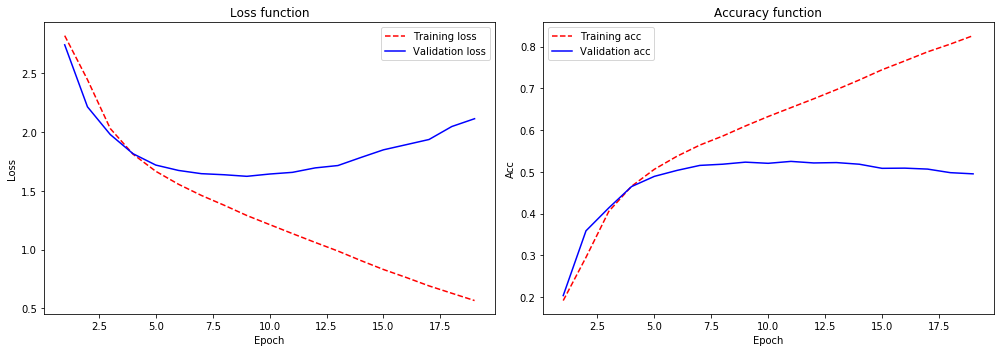

In [23]:
import matplotlib.pyplot as plt
# Get training loss for the model to see if we converged correctly
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,5))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
a0.set_ylabel("Loss")

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.legend()
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
a1.set_ylabel("Acc")

plt.tight_layout()

plt.show()



In [30]:
print(generate_text(model))
# margaret tried up the home that noone else way his head kep

random seed data:  'at although the flat was much '
too bnd woure also well aware that it was not something that she would be sossted for the time being
